In [1]:
# Let's write a multilevel parameter estimation tool:
# PhysiCOOL: A generalized framework for model Calibration and Optimization Of modeLing projects
# David Hormuth,Ines Goncalves,Caleb Phillips, Sandhya Prabhakaran
# revised: 08/23/2021


# Import the necessary libraries
import subprocess
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import physicool

# what is the name of the compiled project?
PROJECT_NAME = './project'  
# Select the cell-specific variables you need to load in for optimization
VARIABLES = ['ID', 'position_x', 'position_y','position_z']
# where is the model output stored?
STORAGE_PATH = Path('output')
# where is the configuration file located?
CONFIG_PATH = Path('config/PhysiCell_settings.xml')
NUMBER_OF_CELLS = 11

In [2]:
def read_output(storage_path, variables):
    #This function will read in location and ID of each cell and return it as "cells_df"
    cells_through_time = []
    timesteps = get_timesteps(storage_path)
    for timestep in timesteps:
        # Read the data saved at each time point
        cells = physicool.get_cell_data(timestep, storage_path, variables)
        number_of_cells = len(cells['ID'])

        # Store the data for each cell
        for i in range(number_of_cells):
            cells_data = [cells[variable][i] for variable in variables] + [timestep]
            cells_through_time.append(cells_data)
            
    cells_df = pd.DataFrame(cells_through_time, columns=['ID', 'x', 'y','z','time'])
    
    return cells_df


def get_timesteps(storage_path):
    """Returns the number of output XML files in the storage directory."""
    number_of_output_files = len(list(storage_path.glob('output*.xml')))
    timesteps = range(number_of_output_files)

    return timesteps

def compute_cell_count(cells_df):
    # This function counts the total number of cells over time
    max_values = cells_df.max()
    last_index = int(max_values['time'])
    total_cell_count =np.zeros(last_index+1);
    z_index = np.unique(cells_df['z'])
    cell_count_rep = np.zeros((last_index+1,len(z_index)+1))

    avg_cell_count = np.zeros((last_index+1))
    lmh_quant = np.zeros((last_index+1,3))

    for n in range( 0,last_index+1 ): # loops through time
        for z in range(0,len(z_index)): # loops through each replicate located in the z-stack
            cell_temp = cells_df[cells_df['time']== n]
            cell_temp = cell_temp[cell_temp['z']== z_index[z]]                            
            cell_count_rep[n][z] = len(cell_temp);

    # We can then calculate the average cell count
    avg_cell_count = cell_count_rep.mean(axis=1)        
    
    # or the 10, 50, and 90th percentiles of the data; 
    for n in range(0,last_index+1):
        temp = cell_count_rep[n];
        lmh_quant[n][0] = np.quantile(temp,.1)
        lmh_quant[n][1] = np.quantile(temp,.5)
        lmh_quant[n][2] = np.quantile(temp,.9)

    return avg_cell_count, lmh_quant, cell_count_rep


def compute_traveled_distances(cells_df):
    distance_traveled_by_cells = []

    # For each cell, compute the Euclidian distances between time points and get the total distance
    for cell_id in range(NUMBER_OF_CELLS):
        single_cell = cells_df[cells_df['ID'] == cell_id]
        # Get the differences between coordinates at every time step
        x_distance_steps = single_cell['x']
        y_distance_steps = single_cell['y']
        # Compute the Euclidian distance for each time step and sum all values
        traveled_distance = np.sqrt(x_distance_steps**2 + y_distance_steps**2)
        
        distance_traveled_by_cells.append(traveled_distance.iloc[-1])
    
    distance_traveled_by_cells = np.array(distance_traveled_by_cells)
    
    return distance_traveled_by_cells


def run_simulation():
    command = PROJECT_NAME
    subprocess.run(command, shell=True) 
    
    
def run_pipeline(params):
    physicool.update_config_file(params, CONFIG_PATH)
    run_simulation()
    cells = read_output(STORAGE_PATH, VARIABLES)
    avg_cc, lmh_quant, cell_count_rep_1 = compute_cell_count(cells)
      
    return avg_cc, lmh_quant

def run_pipeline_avg(params):
    # When calculating the objective function or the Jacobian, it may be beneficial to run the code...
    # several times and then average the replicates of multi-runs
    physicool.update_config_file(params, CONFIG_PATH)
    run_simulation()
    cells = read_output(STORAGE_PATH, VARIABLES)
    avg_cc, lmh_quant, cell_count_rep_1 = compute_cell_count(cells)
    
    run_simulation()
    cells = read_output(STORAGE_PATH, VARIABLES)
    avg_cc_2, lmh_quant_2, cell_count_rep_2 = compute_cell_count(cells)
    
    run_simulation()
    cells = read_output(STORAGE_PATH, VARIABLES)
    avg_cc_3, lmh_quant_3, cell_count_rep_3 = compute_cell_count(cells)
    
    run_simulation()
    cells = read_output(STORAGE_PATH, VARIABLES)
    avg_cc_4, lmh_quant_4, cell_count_rep_4 = compute_cell_count(cells)


    avg_cc = (0.25)*(avg_cc+avg_cc_2+avg_cc_3+avg_cc_4);
    lmh_quant = (0.25)*(lmh_quant+lmh_quant_2+lmh_quant_3+lmh_quant_4)
    
    return avg_cc, lmh_quant

In [3]:
# Generate our surrogate data that we are wanting to estimate model parameters for
params = {'cell/rate': 0.0025}
N_data, lmh_data = run_pipeline(params) # returns cell count over time for a given experiment


NameError: name 'physicool' is not defined

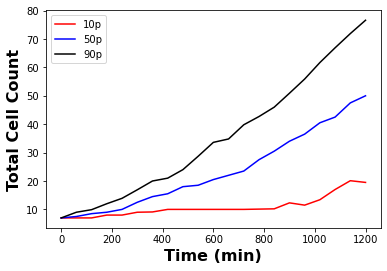

In [38]:
#cells = read_output(STORAGE_PATH, VARIABLES)
#avg_cc, lmh_quant, cell_count_rep_1 = compute_cell_count(cells)
    
X0 = np.linspace(0,1200,20+1)
plt.clf()
plt.plot(X0, lmh_data[:,0] , '-r') 
plt.plot(X0, lmh_data[:,1] , '-b');
plt.plot(X0, lmh_data[:,2] , '-k');

#plt.plot(X0, avg_cc , 'k-' );
plt.xlabel('Time (min)', fontsize=16, fontweight='bold')
plt.ylabel('Total Cell Count', fontsize=16, fontweight='bold')
plt.legend( {'90p','50p','10p'} ) 

In [39]:
# Sweep through model parameters

# Parameter sweep 1 level
number_of_levels = 4
points_per_direction = 10
percent_per_direction = 1
num_params = len(params)
about_point = np.array([0.005])

# Set lower and upperbound for model parameters
param_lb = np.zeros(num_params) # lower bound
param_ub = np.ones(num_params) #upper bound 
param_ub[0] = 0.008;



parameters_in_sweep = np.zeros((num_params,1))
if num_params ==1:
    objective_function = np.zeros((number_of_levels,points_per_direction))
    save_x = np.zeros((number_of_levels,points_per_direction))

else:
    objective_function = np.zeros((number_of_levels,points_per_direction,points_per_direction))
    save_x = np.zeros((number_of_levels,points_per_direction))
    save_y = np.zeros((number_of_levels,points_per_direction))


for n in range(number_of_levels):
    factor = percent_per_direction/(n*2+1)
    # Checks and make sure our parameters are within bounds, and generate parameter sweep
    if n == 0:
        param_1_sweep = np.linspace(param_lb[0],param_ub[0],points_per_direction)
    else:
        param_1_sweep = np.linspace(about_point[0]-factor*about_point[0],about_point[0]+factor*about_point[0],points_per_direction)
    
    param_1_sweep[param_1_sweep<param_lb[0]] = param_lb[0]
    param_1_sweep[param_1_sweep>param_ub[0]] = param_ub[0]
    save_x[n] = param_1_sweep
    print(param_1_sweep)


    if num_params>1:
        if n == 0:
            param_2_sweep = np.linspace(param_lb[1],param_ub[1],points_per_direction)
        else:
            param_2_sweep = np.linspace(about_point[0]-factor*about_point[0],about_point[0]+factor*about_point[0],points_per_direction)
        param_2_sweep[param_2_sweep<param_lb[1]] = param_lb[1]
        param_2_sweep[param_2_sweep>param_ub[1]] = param_ub[1]
        print(param_2_sweep)
        save_y[n] = param_2_sweep


    for a in range(points_per_direction):
        #for b in range(points_per_direction):
        parameters_in_sweep[0] = param_1_sweep[a]
        #parameters_in_sweep[1] = param_2_sweep[b]

        #params = {'cell/speed': prol_sweep[a], 'cell/migration_bias': carcap_sweep[b]}
        params = {'cell/rate': param_1_sweep[a]}

        N_model, lmh_model = run_pipeline(params)
        objective_function[n][a] = ((N_model-N_data)**2).sum()+((lmh_model[:,0]-lmh_data[:,0])**2).sum()+((lmh_model[:,2]-lmh_data[:,2])**2).sum()+((lmh_model[:,1]-lmh_data[:,1])**2).sum()

    I = np.argmin(objective_function[n])
    # I is optimal index, but in references to a points_per_direction X points_per_direcion
    x = int(np.floor(I/points_per_direction))
    #y = int(I-points_per_direction*x)
    
    #about_point[0] = prol_sweep[x]
    #about_point[1] = carcap_sweep[y]
    about_point[0] = param_1_sweep[I]
    print(about_point[0])
    #print(about_point[1])
        

[0.         0.00088889 0.00177778 0.00266667 0.00355556 0.00444444
 0.00533333 0.00622222 0.00711111 0.008     ]
0.002666666666666667
[0.00177778 0.00197531 0.00217284 0.00237037 0.0025679  0.00276543
 0.00296296 0.00316049 0.00335802 0.00355556]
0.0025679012345679016
[0.00205432 0.00216845 0.00228258 0.00239671 0.00251084 0.00262497
 0.00273909 0.00285322 0.00296735 0.00308148]
0.0026249657064471884
[0.00224997 0.0023333  0.00241664 0.00249997 0.0025833  0.00266663
 0.00274996 0.0028333  0.00291663 0.00299996]
0.0024999673394735127


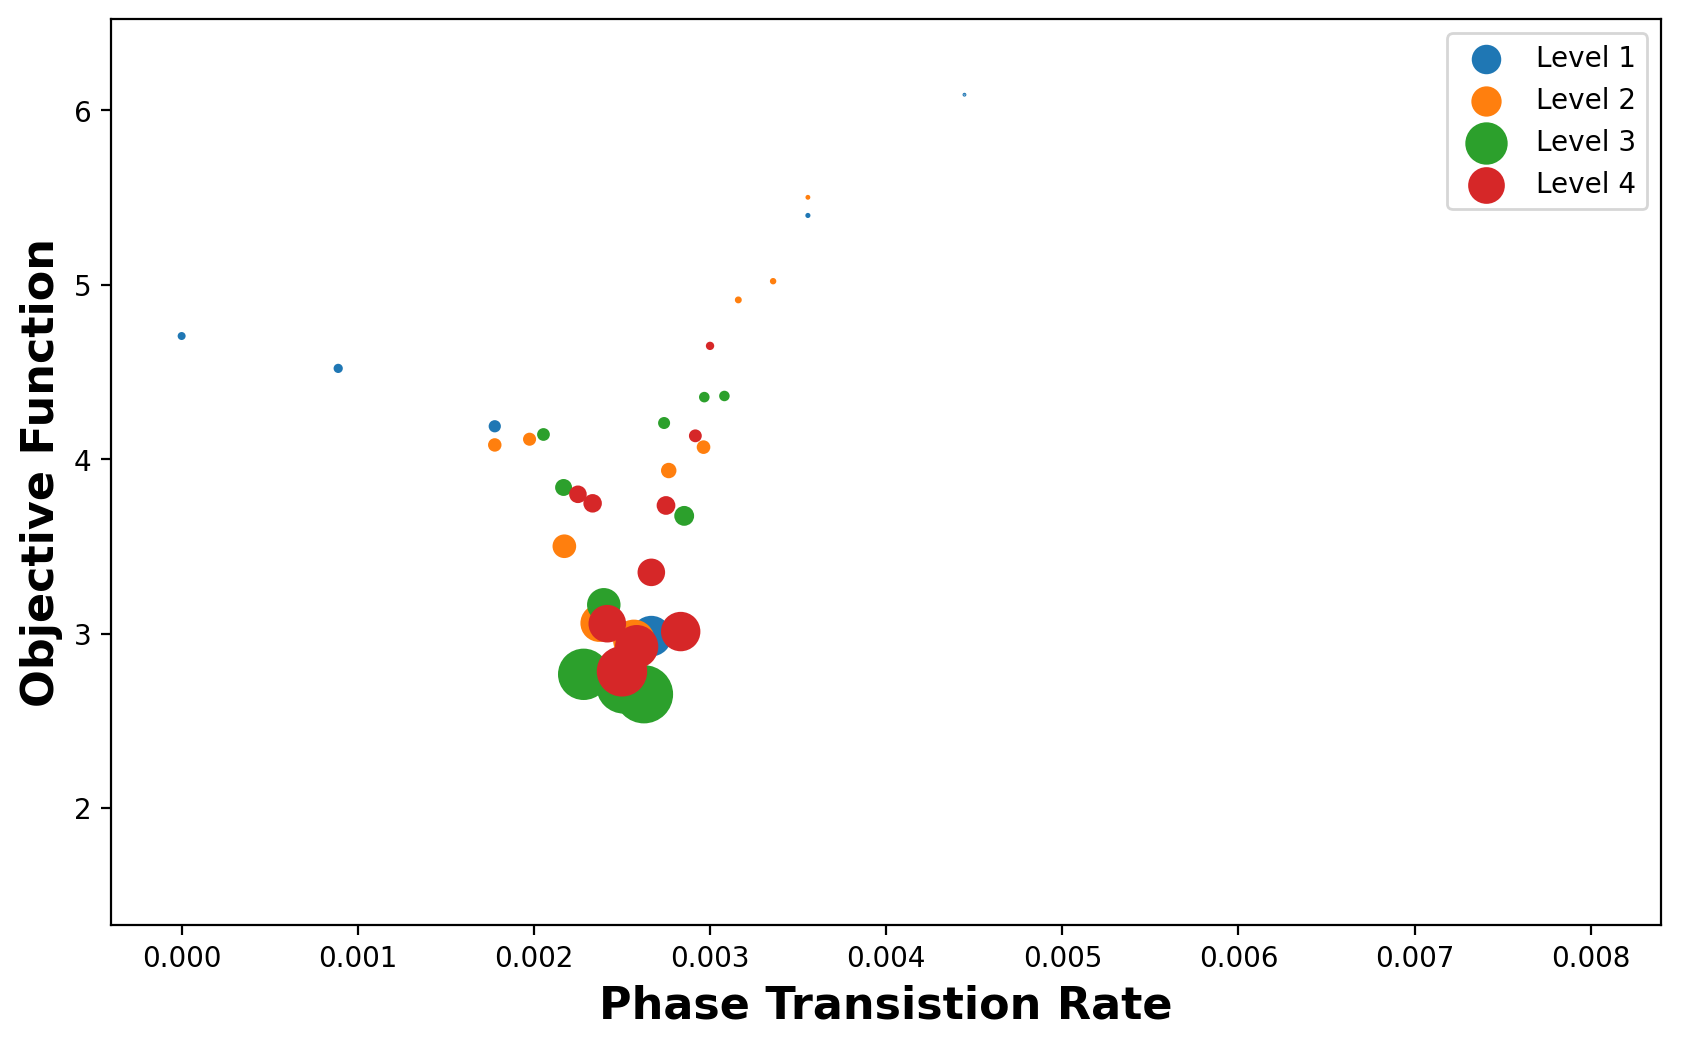

In [40]:
count = 0 
fig = plt.figure(figsize=(10,6),dpi=200) 
for p in range(number_of_levels): 
    #X0 = np.linspace(save_x[count]) 
    X0 = np.meshgrid(save_x[count]) 
    plt.scatter(X0,np.log10(objective_function[count]),s=4*np.max(objective_function[number_of_levels-1])/np.transpose(objective_function[count]),label='Level ' + str(p+1)) 
    plt.xlabel('Phase Transistion Rate', fontsize=16, fontweight='bold') 
    plt.ylabel('Objective Function', fontsize=16, fontweight='bold') 
    plt.ylim([0.5*np.min(np.log10(objective_function)), 1.5*np.mean(np.log10(objective_function))])

    count = count + 1 
    plt.legend()

Iteration: 00. Error: 52894581. Start.
-Iteration: 01. Error: 5502716. Param: 0.0052


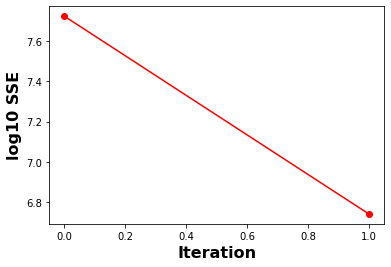

+Iteration: 02. Error: 6424986. Param: 0.0049
-Iteration: 03. Error: 1109983. Param: 0.0046


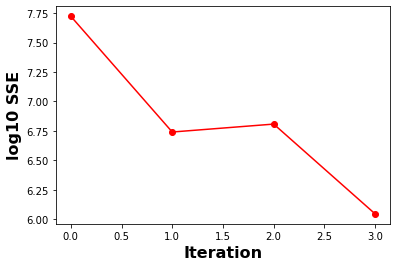

+Iteration: 04. Error: 1266081. Param: 0.0043
-Iteration: 05. Error: 211284. Param: 0.0043


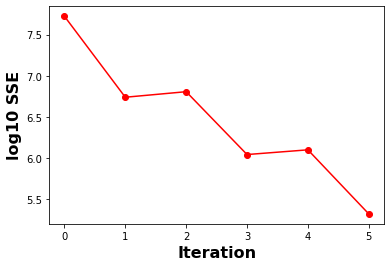

-Iteration: 06. Error: 207069. Param: 0.0041


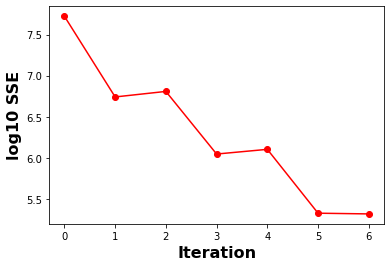

-Iteration: 07. Error: 17966. Param: 0.0035


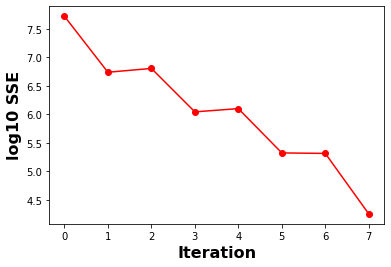

+Iteration: 08. Error: 34885. Param: 0.0033
-Iteration: 09. Error: 664. Param: 0.0033


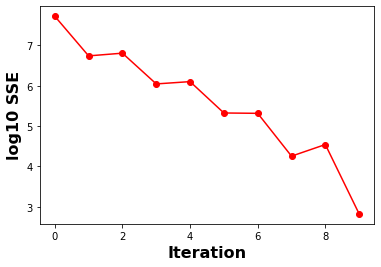

-Iteration: 10. Error: 402. Param: 0.0033


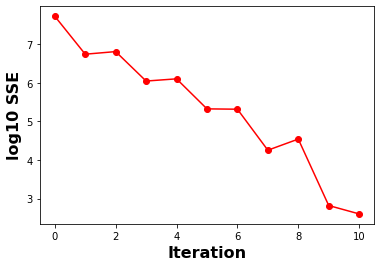

+Iteration: 11. Error: 4519. Param: 0.0034
+Iteration: 12. Error: 1851. Param: 0.0033
+Iteration: 13. Error: 2705. Param: 0.0033
+Iteration: 14. Error: 2427. Param: 0.0033
+Iteration: 15. Error: 4249. Param: 0.0033
+Iteration: 16. Error: 5040. Param: 0.0033
+Iteration: 17. Error: 5674. Param: 0.0033
+Iteration: 18. Error: 3416. Param: 0.0033
+Iteration: 19. Error: 5147. Param: 0.0033
+Iteration: 20. Error: 2920. Param: 0.0033
+Iteration: 21. Error: 4187. Param: 0.0033
+Iteration: 22. Error: 3098. Param: 0.0033
+Iteration: 23. Error: 2248. Param: 0.0033
+Iteration: 24. Error: 3886. Param: 0.0033
+Iteration: 25. Error: 2549. Param: 0.0033
+Iteration: 26. Error: 5015. Param: 0.0033
+Iteration: 27. Error: 2171. Param: 0.0033
+Iteration: 28. Error: 5556. Param: 0.0033
+Iteration: 29. Error: 6149. Param: 0.0033
+Iteration: 30. Error: 5103. Param: 0.0033
+Iteration: 31. Error: 3549. Param: 0.0033
+Iteration: 32. Error: 2243. Param: 0.0033
+Iteration: 33. Error: 3885. Param: 0.0033
+Iteration:

In [63]:
# Levenberg-Marquardt Based approach

lambda_p = 1

param_g = 0.006
param_best = param_g
params = {'cell/rate': param_g}
N_data_p, lmh_data_p = run_pipeline_avg(params) # returns cell count over time for a given experimentlmh_best = lmh_data_p
N_best = N_data_p
#err_best = ((N_best-N_data)**2).sum()
err_test = ((N_data_p-N_data)**2).sum()+((lmh_data_p[:,0]-lmh_data[:,0])**2).sum()+((lmh_data_p[:,2]-lmh_data[:,2])**2).sum()+((lmh_data_p[:,1]-lmh_data[:,1])**2).sum()
err_best = err_test
err_save =np.zeros(200)
iter = 0
err_save[iter] = err_best

print('Iteration: %002d. Error: %2d. Start.' % (iter,err_best))

err_jac = 200
while iter< 199:
    iter = iter+1
    # calculate jacobian
    if err_jac>1:
        param_g = param_best-1e-3
        params = {'cell/rate': param_g}
        N_data_p, lmh_data_p = run_pipeline_avg(params) # returns cell count over time for a given experiment
        N_data_p2, lmh_data_p2 = run_pipeline_avg(params) # returns cell count over time for a given experiment

        J = ((0.5)*(N_data_p2+N_data_p)-N_best)/(-1e-3);
        Jt = np.transpose(J)
        err_jac = 0
   
    # update parameters
    residual = N_data-N_best # residual between model & surrogate data
    delparam = np.dot(Jt,residual)/(np.dot(Jt,J)+lambda_p*np.dot(Jt,J))
    param_g = param_best+delparam
    
    if param_g < 0:
        param_g = 0
    N_data_p, lmh_data_p = run_pipeline_avg(params) # returns cell count over time for a given experiment
    #err_test= ((N_data_p-N_data)**2).sum()
    err_test = ((N_data_p-N_data)**2).sum()+((lmh_data_p[:,0]-lmh_data[:,0])**2).sum()+((lmh_data_p[:,2]-lmh_data[:,2])**2).sum()+((lmh_data_p[:,1]-lmh_data[:,1])**2).sum()

    err_save[iter] = err_test


    # if good change
    if (err_test < err_best):
        print('-Iteration: %002d. Error: %2d. Param: %5.4f' % (iter,err_test,param_g))
        X0 = np.linspace(0,iter,iter+1)
        plt.clf()
        plt.plot(X0, np.log10(err_save[0:iter+1]) , 'o-r') 
        plt.xlabel('Iteration', fontsize=16, fontweight='bold')
        plt.ylabel('log10 SSE', fontsize=16, fontweight='bold')
        plt.show()
        param_best = param_g
        err_best = err_test
        N_best = N_data_p
        lmh_best = lmh_data_p
        lambda_p = lambda_p/1.5
        err_jac = err_jac + 1;

    else:
        print('+Iteration: %002d. Error: %2d. Param: %5.4f' % (iter,err_test,param_g))
        lambda_p = lambda_p*3
        err_jac = err_jac + 0.25

